In [262]:
Packages <- c("dplyr","nleqslv","cubature", "pracma","data.table", "gridExtra","viridis", "ggsignif", "lmtest", "broom", "ggpubr", "caret","cowplot","ggplot2","fields","bbmle", "dplyr", "tidyr", "lubridate", "RColorBrewer")

invisible(suppressPackageStartupMessages(lapply(Packages, library, character.only = TRUE)))

setwd('/local/home/katrinac/parentage/kernel_fitting/')
load("~/parentage/r_data/site_dist_info.RData")
#final scripts to use
source("~/parentage/kernel_fitting/1340_loci/functions/ll_kt_both_bbmle.R")
source("~/parentage/kernel_fitting/1340_loci/functions/ll_kt_both_grid_search.R")
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernInt_sum0.5.R") #integrate_kernel_sum1
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernInt_sum1.R") #integrate_kernel_sum0.5
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernPDF.R")
source("~/parentage/kernel_fitting/1340_loci/functions/cdf_solve.R") 
source("~/parentage/kernel_fitting/1340_loci/functions/cdf_solve90.R") 

#download.file(url = "https://github.com/pinskylab/Clownfish_persistence/blob/master/Data/Data_from_database/fish_db.RData?raw=true", destfile = "~/parentage/r_data/dives_db.RData")
load("~/parentage/r_data/fish_db.RData")
#download.file(url = "https://github.com/pinskylab/Clownfish_persistence/blob/master/Data/Data_from_database/anem_db.RData?raw=true", destfile = "~/parentage/r_data/anem_db.RData")
load("~/parentage/r_data/anem_db.RData")
#download.file(url = "https://github.com/pinskylab/Clownfish_persistence/blob/master/Data/Data_from_database/dives_db.RData?raw=true", destfile = "~/parentage/r_data/dives_db.RData")
load("~/parentage/r_data/dives_db.RData")
#download.file(url = "https://github.com/pinskylab/Clownfish_persistence/blob/master/Data/Data_from_database/fish_db.RData?raw=true", destfile = "~/parentage/r_data/dives_db.RData")
load("~/parentage/r_data/fish_db.RData")
load("~/parentage/r_data/gps_db.RData")
#download.file(url = "https://github.com/pinskylab/Clownfish_persistence/blob/master/Data/anems_tagged.RData", destfile = "~/parentage/r_data/anems_tagged.RData")
load("~/parentage/r_data/anems_tagged.RData")
#download.file(url = "https://github.com/pinskylab/genomics/blob/master/data/fish-obs.RData?raw=true", destfile = "~/parentage/r_data/fish-obs.RData")
fish_obs <- readRDS("~/parentage/r_data/fish-obs.RData") 
fish_meta <- readRDS("~/parentage/r_data/fish_meta.rds")

"%!in%" <- function(x,table) match(x,table, nomatch = 0) == 0

#propsamp load
load("~/parentage/r_data/cumulative_prop_hab_sampled_by_site.RData")

prop_samp <- cumulative_prop_hab_sampled_by_site %>%
    mutate(total_possible_sample_anems = ifelse(site=="Caridad Proper", 4, total_possible_sample_anems) ) %>%
    mutate(total_prop_hab_sampled_anems_tidied= ifelse(site=="Caridad Proper" & total_anems_sampled==4, 1, total_prop_hab_sampled_anems_tidied) ) %>%
    mutate(total_possible_sample_anems = ifelse(site=="Sitio Lonas", total_anems_sampled, total_possible_sample_anems) ) %>%
    mutate(total_prop_hab_sampled_anems_tidied= ifelse(site=="Sitio Lonas", 1, total_prop_hab_sampled_anems_tidied) )



prop_samp$site <- gsub(". ", ".", prop_samp$site, fixed=TRUE)

In [14]:
##from Allison, just putting all the meta data together (Constants_database_common_functions.R)
###### Match up other relevant info (site, date, fish_indiv, etc.) to fish in the clownfish table
## Pull out year and month into a separate column in dives_db
#dives_db_processed <- dives_db %>%
#  mutate(year = as.integer(substring(date,1,4))) %>%
#  mutate(month = as.integer(substring(date,6,7))) %>%
#  mutate(dive_date = date(date))
#
## Pull all APCL caught or otherwise in the clownfish table
#allfish_fish <- fish_db %>%
#  select(fish_table_id, anem_table_id, fish_spp, sample_id, anem_table_id, recap, tag_id, color, sex, size, fish_obs_time) %>%
#  filter(fish_spp == 'APCL') %>%
#  mutate(size = as.numeric(size))  # make the size numeric (rather than chr) so can do means and such
#
## and their corresponding anemones
#allfish_anems <- anem_db %>%
#  select(anem_table_id, dive_table_id, anem_obs, anem_id, old_anem_id, anem_obs_time) %>%
#  filter(anem_table_id %in% allfish_fish$anem_table_id)
#
## and the corresponding dive info
#allfish_dives <- dives_db_processed %>%
#  select(dive_table_id, dive_type, date, year, month, site, gps) %>%
#  filter(dive_table_id %in% allfish_anems$dive_table_id) 
#
## join together
#allfish_caught <- left_join(allfish_fish, allfish_anems, by="anem_table_id")
#allfish_caught <- left_join(allfish_caught, allfish_dives, by="dive_table_id")
#
## add in the gen_ids and fish_indiv (now in a separate gen_id table) - gen_id only comes in the time the fish was sequenced, not at all captures
#allfish_caught <- left_join(allfish_caught, (fish_obs %>% select(fish_table_id, gen_id, fish_indiv)), by = "fish_table_id")
#

In [45]:
#read in fish sample data
#parentage results
par_res <- read.csv(file="~/parentage/colony2/20200605_1340loci/results/parentage_results_allyears.csv", header= T) %>%
    distinct(offs_fish_indiv, .keep_all = T) %>% #just need the sites for parent and offspring, will join to fish metadata with fish_indiv
    select(offs_fish_indiv, par_fish_indiv, offs_site, par_site, year) %>% 
    mutate(offs_fish_indiv=as.character(offs_fish_indiv)) %>%
    rename(year_match="year") #change this year to be the year of the parentage match

#genotyped potential offspring
N_gen_offs <- read.table(file="~/parentage/colony2/20190523_1340loci/input/all_offspring_corrected.txt", header=T, stringsAsFactors = F) %>%
    mutate(input="offspring") %>%
    mutate(fish_indiv=as.character(fish_indiv)) #%>%
    #select(fish_indiv, input, year)
N_gen_offs2 <- left_join(N_gen_offs, fish_meta %>% select(fish_indiv, site) %>% filter(!is.na(fish_indiv)) %>% distinct(fish_indiv, .keep_all = T))

SampledRecruitsPar <- left_join(N_gen_offs2, par_res, by=c(fish_indiv="offs_fish_indiv")) %>%
    mutate(matched_offs= ifelse(!is.na(year_match), "Y", "N"))


SampledRecruitsPar$site <- gsub(". ", ".", SampledRecruitsPar$site, fixed=TRUE)
SampledRecruitsPar$offs_site <- gsub(". ", ".", SampledRecruitsPar$offs_site, fixed=TRUE)
SampledRecruitsPar$par_site <- gsub(". ", ".", SampledRecruitsPar$par_site, fixed=TRUE)

Joining, by = "fish_indiv"


In [46]:
nrow(SampledRecruitsPar) #should be 791
nrow(par_res) #should be 71
head(SampledRecruitsPar)


[1] 791

[1] 71

fish_indiv,year,size,color,sex,gen_id,ligation_id,sample_id,input,site,par_fish_indiv,offs_site,par_site,year_match,matched_offs
762,2012,5.1,Y,J,762,L2436,APCL12_256,offspring,Wangag,236,Wangag,Palanas,2012,Y
2318,2012,4.1,Y,J,2318,L2437,APCL12_275,offspring,Wangag,NA,NA,NA,NA,N
409,2012,4.5,Y,J,409,L2319,APCL12_276,offspring,Wangag,NA,NA,NA,NA,N
2317,2012,5.1,W,J,2317,L2481,APCL12_168,offspring,S.Magbangon,NA,NA,NA,NA,N
2072,2012,4.1,NA,NA,2072,L2210,APCL12_090,offspring,Palanas,NA,NA,NA,NA,N
92,2012,5.4,NA,NA,92,L2212,APCL12_094,offspring,Palanas,NA,NA,NA,NA,N


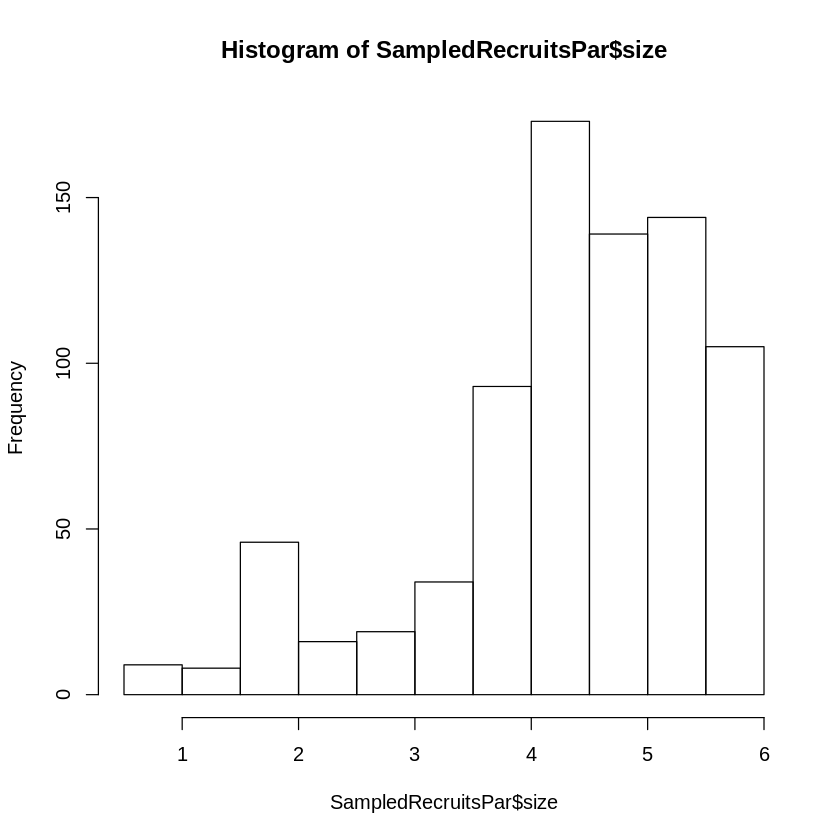

In [40]:
hist(SampledRecruitsPar$size) #nothing should be greater than 6 cm. GOOD!! 

In [208]:
SWM_recruits <- SampledRecruitsPar %>%
    filter(size >=4.5 & size < 6) %>%
    mutate(season="SWM")
NEM_recruits <- SampledRecruitsPar %>%
    filter(size <= 3.5) %>%
    mutate(season="NEM")


In [209]:
#how many fish in each category?
nrow(SWM_recruits)
nrow(NEM_recruits)

nrow(SWM_recruits %>% filter(matched_offs=="Y"))
nrow(NEM_recruits %>% filter(matched_offs=="Y"))

[1] 428

[1] 132

[1] 35

[1] 11

In [210]:
all_seasons <- bind_rows(SWM_recruits, NEM_recruits)

write.csv(all_seasons, file="~/parentage/kernel_fitting/1340_loci/final_results/tables/RecruitsByMonsoon.csv", row.names=F, quote=FALSE)



In [260]:
NEM_input <- NEM_recruits %>%
    filter(matched_offs=="Y")%>%
    select(year, offs_site, par_site)
SWM_input <- SWM_recruits %>% 
    filter(matched_offs=="Y") %>%
    select(year, offs_site, par_site)#%

dim(NEM_input)
dim(SWM_input_samp)

write.csv(NEM_input, file="~/parentage/kernel_fitting/1340_loci/input/20200624_parentage_NEM.csv", quote=TRUE, row.names= FALSE)
write.csv(SWM_input, file="~/parentage/kernel_fitting/1340_loci/input/20200624_parentage_SWM.csv", quote=TRUE, row.names= FALSE)
NEM_input <- NEM_input %>%
    mutate(season="NEM")
SWM_input <- SWM_input %>%
    mutate(season="SWM")
AllRecruits <- bind_rows(NEM_input, SWM_input) %>%
    select(-year)
AllRecruits$offs_site <- gsub(". ", ".", AllRecruits$offs_site, fixed=TRUE)
AllRecruits$par_site <- gsub(". ", ".", AllRecruits$par_site, fixed=TRUE)

write.csv(AllRecruits, file="~/parentage/kernel_fitting/1340_loci/input/20200624_AllSeasonParentage.csv", quote=TRUE, row.names= FALSE)




[1] 11  3

[1] 54  3

In [212]:
N_gen_offs_all <- all_seasons %>% 
    filter(input=="offspring") %>%
    group_by(season, site) %>%
    summarise(n_offs_gen=n())
sum(N_gen_offs_all$n_offs_gen) #missing 5 fish, because they are marked J based on tail color but we don't have their size
#nrow(N_gen_offs %>% filter(fish_indiv %!in% all_seasons$fish_indiv))

[1] 560

In [213]:
#file prep
centroids <- read.csv("~/parentage/kernel_fitting/1340_loci/input/site_centroids.csv", header=TRUE)
sampled_sites <- prop_samp %>% select(site) %>% distinct(site)
sampled_sites$site <- gsub(". ", ".", sampled_sites$site, fixed=TRUE)
site_widths <- read.table("/local/home/katrinac/parentage/text_file/site_widths.txt", header=T, sep=",")

#index sites to get pop numbers
all_sites <- centroids %>%
    select(site) %>%
    arrange(site)
nrow(all_sites) #should be 35x1

all_sites$index <- seq(from=1, to=35, by=1)


total_parSWM <- SWM_recruits %>%
    filter(matched_offs=="Y") %>%
    group_by(offs_site, par_site) %>%
    summarise(n_matches=n()) %>%
    ungroup() 

total_parNEM <- NEM_recruits %>%
    filter(matched_offs=="Y") %>%
    group_by(offs_site, par_site) %>%
    summarise(n_matches=n()) %>%
    ungroup() 

for(i in 1:nrow(prop_samp)){
    
    
    if(is.nan(prop_samp$total_prop_hab_sampled_anems_tidied[i])){prop_samp$total_prop_hab_sampled_anems_tidied[i] <- 0.01} 
    if(is.infinite(prop_samp$total_prop_hab_sampled_anems_tidied[i])){prop_samp$total_prop_hab_sampled_anems_tidied[i] <- 1}
    
    
}

prop_sampSeas <- prop_samp %>%
    filter(time_frame=="2012-2018" & total_prop_hab_sampled_anems_tidied >=0) %>%
    select(site, total_prop_hab_sampled_anems_tidied)

sitesSWM <- prop_sampSeas %>%
    select(site)
sitesSWM_2 <- suppressWarnings(semi_join(all_sites, sitesSWM, by="site")) %>%
    select(index)
sitesSWMt <- t(sitesSWM_2)


sitesSWM_beta <- sitesSWM %>%
    #select(-pop) %>%
    rename(par_site="site")

sitesSWM_beta$offs_site <- sitesSWM_beta$par_site

allsites_parentageSWM <- full_join(sitesSWM_beta, total_parSWM, by=c("par_site", "offs_site")) %>%
    group_by(offs_site, par_site) %>%
    filter(row_number()==1) %>%
    arrange(offs_site, par_site)

##generate list of site indices
sitesNEM <- prop_sampSeas %>%
    select(site)
sitesNEM_2 <- suppressWarnings(semi_join(all_sites, sitesNEM, by="site")) %>%
    select(index)
sitesNEMt <- t(sitesNEM_2)

sitesNEM_beta <- sitesNEM %>%
    #select(-pop) %>%
    rename(par_site="site")

sitesNEM_beta$offs_site <- sitesNEM_beta$par_site

allsites_parentageNEM <- full_join(sitesNEM_beta, total_parNEM, by=c("par_site", "offs_site")) %>%
    group_by(offs_site, par_site) %>%
    filter(row_number()==1) %>%
    arrange(offs_site, par_site)

#turn into a matrix of the correct format
parmatSWM <- allsites_parentageSWM %>% 
    filter(!is.na(offs_site) & !is.na(par_site)) %>%
    group_by(offs_site, par_site) %>%
    filter(row_number()==1) %>%
    spread(offs_site, n_matches)

###change NAs to 0
parmatSWM[is.na(parmatSWM)] <- 0
rownames(parmatSWM) <- suppressWarnings(parmatSWM$par_site)
parmatSWM$par_site <- NULL

#parmatSWM <- (parmatSWM[1:nrow(sitesSWM_beta), 1:nrow(sitesSWM_beta)])
#
#
parmatNEM <- allsites_parentageNEM %>% 
    filter(!is.na(offs_site) & !is.na(par_site)) %>%
    group_by(offs_site, par_site) %>%
    filter(row_number()==1) %>%
    spread(offs_site, n_matches)

##change NAs to 0
parmatNEM[is.na(parmatNEM)] <- 0
rownames(parmatNEM) <- suppressWarnings(parmatNEM$par_site)
parmatNEM$par_site <- NULL

N_gen_offs_all <- all_seasons %>% 
    filter(input=="offspring") %>%
    group_by(season, site) %>%
    summarise(n_offs_gen=n())
sum(N_gen_offs_all$n_offs_gen) #missing 5 fish, because they are marked J based on tail color but we don't have their size
#nrow(N_gen_offs %>% filter(fish_indiv %!in% all_seasons$fish_indiv))

N_gen_offs2 <- N_gen_offs_all %>%
    group_by(site, season) %>% #add group by year if doing annual
    summarise(sampled_fish=sum(n_offs_gen)) 


#make dataframe with column for unassigned juveniles in each column (offspring site)
offs_matched_site <- allsites_parentageSWM %>%
    group_by(offs_site) %>%
    summarise(n_offs=sum(n_matches, na.rm=T))

unassigned_beta <- semi_join(offs_matched_site, sitesSWM, by=c(offs_site="site")) %>%
    ungroup() %>%
    select(offs_site, n_offs)

#unassigned_beta[is.na(unassigned_beta)] <- 0


net_unassigned <- left_join(unassigned_beta, (N_gen_offs2 %>% filter(season=="SWM")), by=c(offs_site="site")) %>%
    mutate(n_unassigned=sampled_fish-n_offs)

net_unassigned$sampled_fish[is.na(net_unassigned$sampled_fish)] <- 0
net_unassigned$n_unassigned[is.na(net_unassigned$n_unassigned)] <- 0

#transpose to create a row, bind to the matrix

row2add <- net_unassigned %>%
    arrange(offs_site) %>%
    select(n_unassigned, offs_site) %>%
    group_by(offs_site) %>%
    filter(row_number()==1) %>%
    ungroup() %>%
    select(n_unassigned)
row2addT <- as.data.frame(t(row2add))
colnames(row2addT) <- colnames(parmatSWM)

parmatSWM <- ungroup(parmatSWM)
parmat_SWM_full <- bind_rows(parmatSWM, row2addT)
parmat_SWM_full[is.na(parmat_SWM_full)] <- 0
parmat_SWM_full[parmat_SWM_full <0 ] <- 0

#make dataframe with column for unassigned juveniles in each column (offspring site)
offs_matched_site <- allsites_parentageNEM %>%
    group_by(offs_site) %>%
    summarise(n_offs=sum(n_matches, na.rm=T))

unassigned_beta <- semi_join(offs_matched_site, sitesNEM, by=c(offs_site="site")) %>%
    ungroup() %>%
    select(offs_site, n_offs)

#unassigned_beta[is.na(unassigned_beta)] <- 0
net_unassigned <- left_join(unassigned_beta, (N_gen_offs2 %>% filter(season=="NEM")), by=c(offs_site="site")) %>%
    mutate(n_unassigned=sampled_fish-n_offs)

net_unassigned$sampled_fish[is.na(net_unassigned$sampled_fish)] <- 0
net_unassigned$n_unassigned[is.na(net_unassigned$n_unassigned)] <- 0

#transpose to create a row, bind to the matrix

row2add <- net_unassigned %>%
    arrange(offs_site) %>%
    select(n_unassigned, offs_site) %>%
    group_by(offs_site) %>%
    filter(row_number()==1) %>%
    ungroup() %>%
    select(n_unassigned)
row2addT <- as.data.frame(t(row2add))
colnames(row2addT) <- colnames(parmatNEM)

parmatNEM <- ungroup(parmatNEM)
parmat_NEM_full <- bind_rows(parmatNEM, row2addT)
parmat_NEM_full[is.na(parmat_NEM_full)] <- 0
parmat_NEM_full[parmat_NEM_full < 0] <- 0

write.csv(parmat_SWM_full, "~/parentage/kernel_fitting/1340_loci/input/20200624_parentage_matrix_SWM.csv",  row.names=FALSE, quote=FALSE)
write.csv(parmat_NEM_full, "~/parentage/kernel_fitting/1340_loci/input/20200624_parentage_matrix_NEM.csv",  row.names=FALSE, quote=FALSE)



[1] 35

Warning message:
“Setting row names on a tibble is deprecated.”Warning message:
“Setting row names on a tibble is deprecated.”

[1] 560

In [214]:
#double check, should all be true
nrow(SWM_recruits) == sum(parmat_SWM_full)
nrow(NEM_recruits) == sum(parmat_NEM_full)

nrow(SWM_recruits %>% filter(matched_offs=="Y"))== sum(parmat_SWM_full[1:19,])
nrow(NEM_recruits %>% filter(matched_offs=="Y"))== sum(parmat_NEM_full[1:19,])




[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

In [217]:
#specify upper and lower bounds for parameters
Assignments <- as.matrix(read.csv("~/parentage/kernel_fitting/1340_loci/input/20200624_parentage_matrix_SWM.csv"))
Adult_sample_proportions <- as.matrix(read.csv("~/parentage/kernel_fitting/1340_loci/input/prop_samp_all.csv", header=FALSE))
Sampled_reefs <- as.matrix(read.csv("~/parentage/kernel_fitting/1340_loci/input/site_index_all.csv", header=FALSE))
Distances <- as.matrix(read.csv("~/parentage/kernel_fitting/894_loci/distance_matrix_unsurveyed.csv", header=FALSE))
Reef_sizes <- as.matrix(read.csv("~/parentage/kernel_fitting/894_loci/area_unsurveyed.csv", header=FALSE))
Centroids <- as.matrix(read.csv("~/parentage/kernel_fitting/894_loci/centroids_unsurveyed.csv", header=T))
#check

sum(Assignments[1:19,])
x <- list(Distances=Distances, Assignments=Assignments, Sampled_reefs=Sampled_reefs, Reef_sizes=Reef_sizes, Adult_sample_proportions=Adult_sample_proportions) #put inputs into a list because that's the bbmle format

fit_bothSWM <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=1), lower=c(-10, 0.15), upper=c(10, 8), method="L-BFGS-B", data=x, control=list(maxit=500)))
fit_bothSWM



MDD_SWM <- cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=coef(fit_bothSWM)[1], theta=coef(fit_bothSWM)[2], method = "pcubature")$integral
MDD_SWM

k_eval <- coef(fit_bothSWM)[1]
theta_eval <- coef(fit_bothSWM)[2]
dist90_SWM <- round(nleqslv(x = 7, fn = cdf_solve90)$x, 2)
dist90_SWM


## use a grid search to find k that minimizes the log likelihood
#k_eval <- c(seq(from=-10, to=10, by=0.01))
#theta_eval <- c(seq(from=0.1, to=5, by=.01))
#nll_matrix <- matrix(data=NA, nrow=length(k_eval), ncol=length(theta_eval), 
#                     dimnames=list(k_eval, theta_eval))
#
##Begin grid search: i <- 1; j <- 1
#for(i in 1:length(k_eval)){
#  k <- k_eval[i]
#  for(j in 1:length(theta_eval)){
#    theta <- theta_eval[j]
#    nll_matrix[i,j] <- LL_kt_grid(k=k, theta=theta, Distances=Distances, Assignments=Assignments, Sampled_reefs=Sampled_reefs, Reef_sizes=Reef_sizes, Adult_sample_proportions=Adult_sample_proportions)
#  }
#}
#
#
#
#
#max(nll_matrix, na.rm = T)
#min(nll_matrix, na.rm = T)
#
#sum(is.na(nll_matrix)==T)
#best_params_index <- which(nll_matrix == min(nll_matrix, na.rm = T), arr.ind=TRUE)
#best_params <- c(k_eval[best_params_index[1]], theta_eval[best_params_index[2]])
#best_params
#
#write.csv(nll_matrix, file="~/parentage/kernel_fitting/1340_loci/final_results/likelihood_profiles_grid_search/profile_SWM.csv", row.names=T, quote=FALSE)



[1] 35


Call:
mle2(minuslogl = LL_kt_bbmle, start = list(k = -3, theta = 1), 
    method = "L-BFGS-B", data = x, lower = c(-10, 0.15), upper = c(10, 
        8), control = list(maxit = 500))

Coefficients:
        k     theta 
-2.602780  1.588406 

Log-likelihood: -221.56 

[1] 8.569808

[1] 18.29

In [216]:
#specify upper and lower Sounds for parameters
Assignments <- as.matrix(read.csv("~/parentage/kernel_fitting/1340_loci/input/20200624_parentage_matrix_NEM.csv", header=TRUE))
Adult_sample_proportions <- as.matrix(read.csv("~/parentage/kernel_fitting/1340_loci/input/prop_samp_all.csv", header=FALSE))
Sampled_reefs <- as.matrix(read.csv("~/parentage/kernel_fitting/1340_loci/input/site_index_all.csv", header=FALSE))
Distances <- as.matrix(read.csv("~/parentage/kernel_fitting/894_loci/distance_matrix_unsurveyed.csv", header=FALSE))
Reef_sizes <- as.matrix(read.csv("~/parentage/kernel_fitting/894_loci/area_unsurveyed.csv", header=FALSE))
Centroids <- as.matrix(read.csv("~/parentage/kernel_fitting/894_loci/centroids_unsurveyed.csv", header=T))
#check
sum(Assignments[1:19,])

x <- list(Distances=Distances, Assignments=Assignments, Sampled_reefs=Sampled_reefs, Reef_sizes=Reef_sizes, Adult_sample_proportions=Adult_sample_proportions) #put inputs into a list because that's the bbmle format

fit_bothNEM <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=1), lower=c(-10, 0.15), upper=c(10, 8), method="L-BFGS-B", data=x, control=list(maxit=500)))
fit_bothNEM



MDD_NEM <- cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=coef(fit_bothNEM)[1], theta=coef(fit_bothNEM)[2], method = "pcubature")$integral
MDD_NEM

k_eval <- coef(fit_bothNEM)[1]
theta_eval <- coef(fit_bothNEM)[2]
dist90_NEM <- round(nleqslv(x = 7, fn = cdf_solve90)$x, 2)
dist90_NEM



[1] 11


Call:
mle2(minuslogl = LL_kt_bbmle, start = list(k = -3, theta = 1), 
    method = "L-BFGS-B", data = x, lower = c(-10, 0.15), upper = c(10, 
        8), control = list(maxit = 500))

Coefficients:
         k      theta 
-0.8910406  0.5609519 

Log-likelihood: -62.26 

[1] 9.400232

[1] 23.48

In [ ]:
#02/20/2020 -- these two lines below are for getting a more realistic plot in null_dispersal.ipynb seasonal section
#I think it was artifically too high just by chance getting really different kernels 
MDD <- c(MDD_NEM, MDD_SWM)
cvMDD=sd(MDD)/mean(MDD, na.rm=T)
cvMDD

[1] 1.233397

In [219]:
Assignments <- as.matrix(read.csv("~/parentage/kernel_fitting/1340_loci/input/20200624_parentage_matrix_NEM.csv", header=TRUE))
Adult_sample_proportions <- as.matrix(read.csv("~/parentage/kernel_fitting/1340_loci/input/prop_samp_all.csv", header=FALSE))
Sampled_reefs <- as.matrix(read.csv("~/parentage/kernel_fitting/1340_loci/input/site_index_all.csv", header=FALSE))
Distances <- as.matrix(read.csv("~/parentage/kernel_fitting/894_loci/distance_matrix_unsurveyed.csv", header=FALSE))
Reef_sizes <- as.matrix(read.csv("~/parentage/kernel_fitting/894_loci/area_unsurveyed.csv", header=FALSE))
Centroids <- as.matrix(read.csv("~/parentage/kernel_fitting/894_loci/centroids_unsurveyed.csv", header=T))

# use a grid search to find k that minimizes the log likelihood
k_eval <- c(seq(from=-10, to=10, by=0.01))
theta_eval <- c(seq(from=0.15, to=5, by=0.01))
nll_matrix <- matrix(data=NA, nrow=length(k_eval), ncol=length(theta_eval), 
                     dimnames=list(k_eval, theta_eval))

x <- length(k_eval)
pb <- txtProgressBar(min = 0, max =x, style = 3)

#Begin grid search: i <- 1; j <- 1
for(i in 1:length(k_eval)){
  k <- k_eval[i]
  for(j in 1:length(theta_eval)){
    theta <- theta_eval[j]
    nll_matrix[i,j] <- LL_kt_grid(k=k, theta=theta, Distances=Distances, Assignments=Assignments, Sampled_reefs=Sampled_reefs, Reef_sizes=Reef_sizes, Adult_sample_proportions=Adult_sample_proportions)
  }

    setTxtProgressBar(pb, i)
    
}
close(pb)




max(nll_matrix, na.rm = T)
min(nll_matrix, na.rm = T)

sum(is.na(nll_matrix)==T)
best_params_index <- which(nll_matrix == min(nll_matrix, na.rm = T), arr.ind=TRUE)
best_params <- c(k_eval[best_params_index[1]], theta_eval[best_params_index[2]])
best_params

write.csv(nll_matrix, file="~/parentage/kernel_fitting/1340_loci/final_results/likelihood_profiles_grid_search/profile_NEM.csv", row.names=T, quote=FALSE)



  |======================================================================| 100%


[1] 415.3584

[1] 62.25946

[1] 0

[1] -0.89  0.56

In [220]:
Assignments <- as.matrix(read.csv("~/parentage/kernel_fitting/1340_loci/input/20200624_parentage_matrix_SWM.csv"))
Adult_sample_proportions <- as.matrix(read.csv("~/parentage/kernel_fitting/1340_loci/input/prop_samp_all.csv", header=FALSE))
Sampled_reefs <- as.matrix(read.csv("~/parentage/kernel_fitting/1340_loci/input/site_index_all.csv", header=FALSE))
Distances <- as.matrix(read.csv("~/parentage/kernel_fitting/894_loci/distance_matrix_unsurveyed.csv", header=FALSE))
Reef_sizes <- as.matrix(read.csv("~/parentage/kernel_fitting/894_loci/area_unsurveyed.csv", header=FALSE))
Centroids <- as.matrix(read.csv("~/parentage/kernel_fitting/894_loci/centroids_unsurveyed.csv", header=T))

# use a grid search to find k that minimizes the log likelihood
k_eval <- c(seq(from=-10, to=10, by=0.01))
theta_eval <- c(seq(from=0.15, to=5, by=.01))
nll_matrix <- matrix(data=NA, nrow=length(k_eval), ncol=length(theta_eval), 
                     dimnames=list(k_eval, theta_eval))

x <- length(k_eval)
pb <- txtProgressBar(min = 0, max =x, style = 3)

#Begin grid search: i <- 1; j <- 1
for(i in 1:length(k_eval)){
  k <- k_eval[i]
  for(j in 1:length(theta_eval)){
    theta <- theta_eval[j]
    nll_matrix[i,j] <- LL_kt_grid(k=k, theta=theta, Distances=Distances, Assignments=Assignments, Sampled_reefs=Sampled_reefs, Reef_sizes=Reef_sizes, Adult_sample_proportions=Adult_sample_proportions)
  }
    
    setTxtProgressBar(pb, i)
    
}

close(pb)



max(nll_matrix, na.rm = T)
min(nll_matrix, na.rm = T)

sum(is.na(nll_matrix)==T)
best_params_index <- which(nll_matrix == min(nll_matrix, na.rm = T), arr.ind=TRUE)
best_params <- c(k_eval[best_params_index[1]], theta_eval[best_params_index[2]])
best_params

write.csv(nll_matrix, file="~/parentage/kernel_fitting/1340_loci/final_results/likelihood_profiles_grid_search/profile_SWM.csv", row.names=T, quote=FALSE)



  |======================================================================| 100%


[1] 1286.321

[1] 221.5561

[1] 0

[1] -2.60  1.58

In [263]:
#read in data and explore what kernels and MDD look like along the ridgeline
profile_NEM <- read.csv(file="~/parentage/kernel_fitting/1340_loci/final_results/likelihood_profiles_grid_search/profile_NEM.csv", header=T) %>%
  rename(k_eval= "X") 
#profile is the exported csv of the matrix of LL values I computed with a grid search of 2012 combinations of k from -10-10 by 0.001 and theta from 0.1-5 by 0.001
#the lowest positive LL value corresponds to the MLE
profile_SWM <- read.csv(file="~/parentage/kernel_fitting/1340_loci/final_results/likelihood_profiles_grid_search/profile_SWM.csv", header=T) %>%
  rename(k_eval= "X") 

In [273]:
#search and replace for seasons

profile_SWM_df <- profile_SWM %>%
    gather(2:487, key="theta_eval", value="log_like")

#get rid of the X that read.csv inserted
profile_SWM_df$theta_eval <- gsub("X","", profile_SWM_df$theta_eval, fixed=T)
profile_SWM_df$theta_eval <- as.numeric(profile_SWM_df$theta_eval)
#find best fit
best_fit_SWM <- profile_SWM_df %>%
    filter(log_like==min(log_like))

#find 95% CI, using instructions from Ben Bolker's Ecological Models in R and https://public.wsu.edu/~jesse.brunner/classes/bio572/Lab6_Likelihood.html
best_ll_SWM <- as.numeric(best_fit_SWM$log_like)
best_k_SWM <- as.numeric(best_fit_SWM$k_eval)
best_theta_SWM <- as.numeric(best_fit_SWM$theta_eval)
cutoff_SWM <- best_ll_SWM + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#cutoff=_B6.534


profile_SWM_df95 <- profile_SWM_df %>% 
        filter(log_like < cutoff_SWM)

#pull out the values above the cutoff


lower_profile_SWM <- profile_SWM_df95 %>%
    filter(k_eval <= best_k_SWM & theta_eval <= best_theta_SWM)


upper_profile_SWM <- profile_SWM_df95 %>%
    filter(k_eval >= best_k_SWM & theta_eval >= best_theta_SWM)

upper_SWM <- upper_profile_SWM %>%
    filter(log_like== max(log_like))
lower_SWM <- lower_profile_SWM %>%
    filter(log_like== max(log_like))

upper_k_SWM <- as.numeric(upper_SWM %>%
                          select(k_eval))
upper_theta_SWM <- as.numeric(upper_SWM %>%
                          select(theta_eval))
lower_k_SWM <- as.numeric(lower_SWM %>%
                          select(k_eval))
lower_theta_SWM <- as.numeric(lower_SWM %>%
                          select(theta_eval))
upper_k_SWM
lower_k_SWM

upper_theta_SWM
lower_theta_SWM

best_k_SWM
best_theta_SWM


#write.csv(profile_SWM_df95, file="~/parentage/kernel_fitting/1340_loci/final_results/likelihood_profiles_grid_search/profile95CI_SWM.csv", row.names=T, quote=FALSE)


[1] -2.47

[1] -2.63

[1] 1.59

[1] 1.34

[1] -2.6

[1] 1.58

In [242]:
#median distributions
#get the cumulative pdf values for each distance, find the distance where the cumulative is 0.25 (median of the 0.5 AUC kernel)
#select 1000 parameter sets to calculate the median

min_SWM <- min(profile_SWM_df95$log_like)

med_SWM_weighted <- profile_SWM_df95 %>%
        mutate(deviation=min_SWM/log_like) %>%
        sample_n(size=1000, weight=deviation, replacement=T) #%>%
        #mutate(Year=20_SWM)

med_SWM_weighted$MedianDispDist <- NA

pb <- txtProgressBar(min = 0, max =1000, style = 3)

for(j in 1:nrow(med_SWM_weighted)){
    
theta_eval <- med_SWM_weighted$theta_eval[j]
k_eval <- med_SWM_weighted$k_eval[j]

med_SWM_weighted$MedianDispDist[j] <- round(nleqslv(x = 7, fn = cdf_solve)$x, 2) # answer is stored in $x
med_SWM_weighted$Dist90Retained[j] <- round(nleqslv(x = 7, fn = cdf_solve90)$x, 2)
    setTxtProgressBar(pb, j)

}
close(pb)
#write.csv(med_SWM_weighted, file="~/parentage/kernel_fitting/1340_loci/final_results/mean_disp_dist/MedPdf_SWM.csv", row.names=T, quote=FALSE)


  |======================================================================| 100%


In [239]:
#get a distribution of MDD from the combinations of theta and k that are below the cutoff for LL
mdd_NEM <- cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=best_k_NEM, theta=best_theta_NEM, , method = "pcubature")$integral


profile_NEM_df95 <- profile_NEM_df %>% 
        filter(log_like < cutoff_NEM) 
col= "mdd"
mdd_NEM_df <- as.data.frame(matrix(nrow=nrow(profile_NEM_df95), ncol=1))
colnames(mdd_NEM_df) <- col


start <- Sys.time()
for(i in 1:nrow(profile_NEM_df95)){
    
    k_eval <- as.numeric(profile_NEM_df95$k_eval)[i]
    theta_eval <- as.numeric(profile_NEM_df95$theta_eval)[i]
    mdd_eval <-  as.data.frame(as.matrix(cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=k_eval, theta=theta_eval, relTol = 1e-05,  method = "pcubature")$integral))
    mdd_NEM_df[i,] <-  mdd_eval
    
    }
end <- Sys.time()
end-start
#write.csv(mdd_NEM_df, file="~/parentage/kernel_fitting/1340_loci/final_results/mean_disp_dist/MeanDispDist95CI_NEM.csv", quote=FALSE, row.names=F )



Time difference of 26.19188 secs

In [266]:
head(MedNEM)
head(MedSWM)

X,k_eval,theta_eval,log_like,deviation,MedianDispDist,Dist90Retained
1,-1.20,0.51,64.53509,0.9647380,8.75,46.23
2,-2.58,1.15,64.76358,0.9613344,8.06,24.87
3,-2.01,0.71,65.20731,0.9547926,8.46,34.75
4,-3.04,2.64,65.16334,0.9554369,9.62,21.52
5,-2.15,0.94,63.09654,0.9867334,6.37,21.91
6,-2.49,1.62,65.19140,0.9550256,6.10,16.09


X,k_eval,theta_eval,log_like,deviation,MedianDispDist,Dist90Retained
1,-2.65,1.84,222.3778,0.9963048,6.88,17.29
2,-2.64,1.62,221.6200,0.9997115,7.09,18.70
3,-2.59,1.63,221.7229,0.9992476,6.73,17.70
4,-2.86,2.66,224.2882,0.9878184,8.03,17.93
5,-2.54,1.72,224.3903,0.9873694,6.28,16.19
6,-2.91,2.40,222.9953,0.9935458,8.52,19.59


In [245]:
MedNEM <- read.csv(file="~/parentage/kernel_fitting/1340_loci/final_results/mean_disp_dist/MedPdf_NEM.csv", header=T) %>% 
        filter(log_like < cutoff_NEM) 
MedSWM <- read.csv(file="~/parentage/kernel_fitting/1340_loci/final_results/mean_disp_dist/MedPdf_SWM.csv", header=T)%>% 
        filter(log_like < cutoff_SWM) 

#make a summary table
col <- c("Season","RecruitSizeAtSampling", "best_k", "best_theta","k_CI95_lower","k_CI95_upper", "theta_CI95_lower", "theta_CI95_upper", "MeanDispersalDistance","MeanDispDist_CI95_lower", "MeanDispDist_CI95_upper", "MedianDispersalDistance", "MedianDispDist_CI95_lower", "MedianDispDist_CI95_upper")
seasonality_summary <- as.data.frame(matrix(nrow=2, ncol=length(col)))
colnames(seasonality_summary) <- col

theta_eval=best_theta_SWM
k_eval=best_k_SWM
MLE_median_SWM <- round(nleqslv(x = 7, fn = cdf_solve)$x, 2) # answer is stored in $x
MLE_90_SWM <- round(nleqslv(x = 7, fn = cdf_solve90)$x, 2)

theta_eval=best_theta_NEM
k_eval=best_k_NEM
MLE_median_NEM <- round(nleqslv(x = 7, fn = cdf_solve)$x, 2) # answer is stored in $x
MLE_90_NEM <- round(nleqslv(x = 7, fn = cdf_solve90)$x, 2)


seasonality_summary$MedianDispersalDistance <- c(MLE_median_SWM, MLE_median_NEM)
seasonality_summary$Dist90Retained <- c(MLE_90_SWM, MLE_90_NEM)


MDD_SWM <- cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=best_k_SWM, theta=best_theta_SWM, relTol = 1e-05,  method = "pcubature")$integral
MDD_NEM <- cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=best_k_NEM, theta=best_theta_NEM, relTol = 1e-05,  method = "pcubature")$integral

seasonality_summary$Season <- c("SWM", "NEM")
seasonality_summary$RecruitSizeAtSampling <- c("> 4.5 cm", "< 3.5 cm")
seasonality_summary$best_k <- c(best_k_SWM, best_k_NEM)
seasonality_summary$best_theta <- c(best_theta_SWM, best_theta_NEM)
seasonality_summary$k_CI95_lower <- c(lower_k_SWM, lower_k_NEM)
seasonality_summary$k_CI95_upper <- c(upper_k_SWM, upper_k_NEM)
seasonality_summary$theta_CI95_lower <- c(lower_theta_SWM, lower_theta_NEM)
seasonality_summary$theta_CI95_upper <- c(upper_theta_SWM, upper_theta_NEM)
seasonality_summary$MeanDispersalDistance <- c(MDD_SWM, MDD_NEM)
seasonality_summary$MeanDispDist_CI95_lower <- c(min(mdd_SWM_df$mdd), min(mdd_NEM_df$mdd))
seasonality_summary$MeanDispDist_CI95_upper <- c(max(mdd_SWM_df$mdd), max(mdd_NEM_df$mdd))
seasonality_summary$MedianDispDist_CI95_lower <- c(min(med_SWM_weighted$MedianDispDist), min(med_NEM_weighted$MedianDispDist))
seasonality_summary$MedianDispDist_CI95_upper <- c(max(med_SWM_weighted$MedianDispDist), max(med_NEM_weighted$MedianDispDist))



write.csv(seasonality_summary, file="~/parentage/kernel_fitting/1340_loci/final_results/tables/RecruitSizeAsSeasonlity_summary.csv", quote=F, row.names=F)



In [252]:
seasonality_summary

Season,RecruitSizeAtSampling,best_k,best_theta,k_CI95_lower,k_CI95_upper,theta_CI95_lower,theta_CI95_upper,MeanDispersalDistance,MeanDispDist_CI95_lower,MeanDispDist_CI95_upper,MedianDispersalDistance,MedianDispDist_CI95_lower,MedianDispDist_CI95_upper,Dist90Retained
SWM,> 4.5 cm,-2.60,1.58,-2.63,-2.47,1.34,1.59,8.574871,7.132250,10.39623,6.87,4.93,9.28,18.32
NEM,< 3.5 cm,-0.89,0.56,-1.46,-0.74,0.54,0.61,9.446898,6.014163,4272.46841,4.82,3.24,323.37,23.60


In [30]:
surface_NEM <- ggplot(profile_NEM_df, aes(x = k_eval, y = theta_eval)) + 
    geom_tile(aes(fill = as.numeric(log_like), colour=as.numeric(log_like))) + 
    geom_point(aes(x = best_k_NEM, y = best_theta_NEM), colour="white") +
    scale_x_continuous(breaks = seq(-10, 10, by = 1), expand = c(0,0)) + 
    scale_y_continuous(breaks = seq(0.1, 3, by = 1), expand = c(0,0)) +
    scale_fill_viridis(option="magma", name="Log-like") + 
    scale_color_viridis(option="magma", name="Log-like") + 
    theme_bw() + 
    stat_contour(aes(z = log_like), breaks = cutoff_NEM, colour="white") 
#surface_NEM
#ggplot2::ggsave(filename="surface_withCI_NEM.png",  plot=surface_NEM, path="~/parentage/kernel_fitting/1340_loci/final_results")

#zoom12 <- profile12_df %>% filter(k_eval > -2 & k_eval <2) %>% filter(theta_eval >.5 & theta_eval <1.5)

#zoom12 <- ggplot(zoom12, aes(x = k_eval, y = theta_eval)) + 
#    geom_tile(aes(fill = as.numeric(log_like), colour=as.numeric(log_like))) + 
#    geom_point(aes(x = best_k, y = best_theta), colour="white") +
#    scale_x_continuous(breaks = seq(-.1, 1, by = 1)) + 
#    scale_y_continuous(breaks = seq(0.1, 2, by = 1)) +
#    scale_fill_viridis(option="magma", name="Log-like") + 
#    scale_color_viridis(option="magma", name="Log-like") + 
#    theme_bw() + 
#    stat_contour(aes(z = log_like), breaks = cutoff) 
#zoom12
#ggplot2::ggsave(filename="surface_withCI_2012_zoom.pdf",  plot=zoom12, path="~/parentage/kernel_fitting/1240_loci/results", dpi="retina")
#
#

# read in summary after for plotting 



In [47]:
seasonality_summary <- read.csv(file="~/parentage/kernel_fitting/1340_loci/final_results/tables/RecruitSizeAsSeasonlity_summary.csv", header=T)

In [276]:
nrow(profile_NEM_df95)

[1] 15498

In [274]:
profile_NEM_df95_plot <- profile_NEM_df95
profile_SWM_df95_plot <- profile_SWM_df95


profile_NEM_df95_plot$type <- "Northeast Monsoon Recruits"
profile_SWM_df95_plot$type <- "Southwest Monsoon Recruits"

profiles_df <- bind_rows( profile_NEM_df95_plot, profile_SWM_df95_plot,)

In [250]:
cubintegrate(integrate_kernel_sum0.5, k=seasonality_summary$best_k[1], theta=seasonality_summary$best_theta[1], 0, 30, method = "pcubature")$integral
cubintegrate(integrate_kernel_sum0.5, k=seasonality_summary$best_k[2], theta=seasonality_summary$best_theta[2], 0, 30, method = "pcubature")$integral


[1] 0.4941126

[1] 0.4674363

## plot surfaces together 

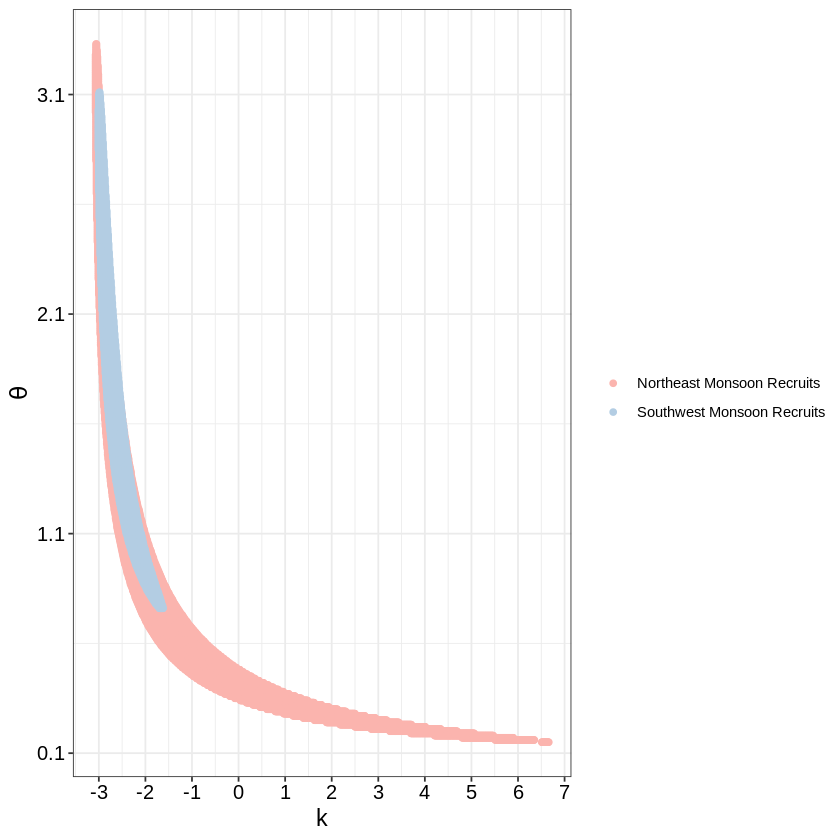

In [275]:

CI_surfaces <- ggplot() + 
    geom_point(data=profiles_df, mapping=aes(x=k_eval, y=theta_eval, colour=type, fill=type))+
    scale_x_continuous(breaks = seq(-12, 12, by = 1)) + 
    scale_y_continuous(breaks = seq(0.1, 8, by = 1)) +
    scale_colour_brewer(type="seq",palette = "Pastel1")+
    theme_bw() +
    theme(legend.title=element_blank(),
    axis.text.x = element_text(size=12, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=12, color="black", family="Helvetica"),
    axis.title.y =  element_text(size=14, color="black", family="Helvetica"), 
    axis.title.x =  element_text(size=14, color="black", family="Helvetica")) +
    xlab("k") + ylab(expression(theta)) 




CI_surfaces

#ggplot2::ggsave(filename="Seasonality95CISurfacesCombined.png",  plot=CI_surfaces, path="~/parentage/kernel_fitting/1340_loci/final_results/likelihood_profiles_grid_search/")


In [269]:
seasonality_summary

Season,RecruitSizeAtSampling,best_k,best_theta,k_CI95_lower,k_CI95_upper,theta_CI95_lower,theta_CI95_upper,MeanDispersalDistance,MeanDispDist_CI95_lower,MeanDispDist_CI95_upper,MedianDispersalDistance,MedianDispDist_CI95_lower,MedianDispDist_CI95_upper,Dist90Retained
SWM,> 4.5 cm,-2.60,1.58,-2.63,-2.47,1.34,1.59,8.574871,7.132250,10.39623,6.87,4.93,9.28,18.32
NEM,< 3.5 cm,-0.89,0.56,-1.46,-0.74,0.54,0.61,9.446898,6.014163,4272.46841,4.82,3.24,323.37,23.60


## plot kernels

In [254]:

##find best fit
#best_fit_NEM <- profile_NEM_df %>%
#    filter(log_like==min(log_like))
#
##find 95% CI, using instructions from Ben Bolker's Ecological Models in R and https://public.wsu.edu/~jesse.brunner/classes/bio572/Lab6_Likelihood.html
#best_ll_NEM <- as.numeric(best_fit_NEM$log_like)
#best_k_NEM <- as.numeric(best_fit_NEM$k_eval)
#best_theta_NEM <- as.numeric(best_fit_NEM$theta_eval)
#cutoff_NEM <- best_ll_NEM + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
##cutoff=_NEM6.534

profile_NEM_df95 <- profile_NEM_df95 %>% 
        filter(log_like < cutoff_NEM) %>%
        sample_n(100)


#k_NEM <- as.numeric(seasonality_summary %>%
#                     filter(RecruitSizeAtSampling=="< 3 cm") %>%
#                     select(best_k))
#theta_NEM <- as.numeric(seasonality_summary %>%
#                     filter(RecruitSizeAtSampling=="< 3 cm") %>%
#                     select(best_theta))
#
#MDD_NEM <- as.numeric(seasonality_summary %>%
#                     filter(RecruitSizeAtSampling=="< 3 cm") %>%
#                     select(MeanDispersalDistance))

#make a df of possible seasonality_summary from 95% CI k
#kCI_NEM <- as.matrix(seq(from=upperk_NEM, to=lowerk_NEM, length.out = 50)) #replace to with -10 for 20_NEM
#thetaCI_NEM <- as.matrix(seq(from=uppertheta_NEM, to=lowertheta_NEM, length.out = 50)) #replace to with -10 for 20_NEM



max_dist <- 60
possible_dist <- matrix(seq(0,max_dist,0.1))
to_plot_NEM <- matrix(nrow=nrow(profile_NEM_df95), ncol=nrow(possible_dist))

for(i in 1:nrow(profile_NEM_df95)) {
     
    k <- profile_NEM_df95$k_eval[i]
    theta <- profile_NEM_df95$theta_eval[i]
    
    for(j in 1:nrow(possible_dist)) {
    
    dist <- possible_dist[j]
    to_plot_NEM[i,j] <- predicted_disp(k=k, theta=theta, d=dist)
    
    }
}

to_plot_NEM_df <- as.data.frame(to_plot_NEM) 
col <- as.character(possible_dist)
colnames(to_plot_NEM_df) <- col
to_plot_NEM_df <- bind_cols(profile_NEM_df95, to_plot_NEM_df)
##colnames(to_plot_NEM_df) <- gsub("-", "k", colnames(to_plot_NEM_df), fixed=TRUE)

to_plot_NEM_df2 <- to_plot_NEM_df %>%
    gather(4:604, key=dist, value=pdf) %>%
    mutate(dist=as.numeric(dist))
to_plot_NEM_df2$iter <- paste0(to_plot_NEM_df2$k_eval, '_', to_plot_NEM_df2$theta_eval) # create an identifier for each sample from the LL surface

dim(to_plot_NEM_df2)
#to_plot_NEM_df2$dist <- seq(0,max_dist,0.1)
#
##make a df to project the kernel
kernel_NEM <- data.frame(dist=seq(0,max_dist,0.1))
k= best_k_NEM
theta=best_theta_NEM

kernel_NEM <- kernel_NEM %>%
    mutate(pdf= predicted_disp(k=k, theta=theta, d=dist))




[1] 60100     6

In [255]:
head(profile_SWM_df95)


k_eval,theta_eval,log_like
-1.70,0.76,224.5447
-1.69,0.76,224.5102
-1.68,0.76,224.4851
-1.67,0.76,224.4698
-1.66,0.76,224.4646
-1.65,0.76,224.4699


In [256]:
profile_SWM_df95 <- profile_SWM_df95 %>% 
        filter(log_like < cutoff_SWM) %>%
        sample_n(100)

#k_SWM <- as.numeric(seasonality_summary %>%
#                     filter(RecruitSizeAtSampling=="> 3 cm") %>%
#                     select(best_k))
#theta_SWM <- as.numeric(seasonality_summary %>%
#                     filter(RecruitSizeAtSampling=="> 3 cm") %>%
#                     select(best_theta))
#
#MDD_SWM <- as.numeric(seasonality_summary %>%
#                     filter(RecruitSizeAtSampling=="> 3 cm") %>%
#                     select(MeanDispersalDistance))
#


max_dist <- 60
possible_dist <- matrix(seq(0,max_dist,0.1))
to_plot_SWM <- matrix(nrow=nrow(profile_SWM_df95), ncol=nrow(possible_dist))

for(i in 1:nrow(profile_SWM_df95)) {
     
    k <- profile_SWM_df95$k_eval[i]
    theta <- profile_SWM_df95$theta_eval[i]
    
    for(j in 1:nrow(possible_dist)) {
    
    dist <- possible_dist[j]
    to_plot_SWM[i,j] <- predicted_disp(k=k, theta=theta, d=dist)
    
    }
}

to_plot_SWM_df <- as.data.frame(to_plot_SWM) 
col <- as.character(possible_dist)
colnames(to_plot_SWM_df) <- col
to_plot_SWM_df <- bind_cols(profile_SWM_df95, to_plot_SWM_df)
##colnames(to_plot_SWM_df) <- gsub("-", "k", colnames(to_plot_SWM_df), fixed=TRUE)

to_plot_SWM_df2 <- to_plot_SWM_df %>%
    gather(4:604, key=dist, value=pdf) %>%
    mutate(dist=as.numeric(dist))
to_plot_SWM_df2$iter <- paste0(to_plot_SWM_df2$k_eval, '_', to_plot_SWM_df2$theta_eval) # create an identifier for each sample from the LL surface

dim(to_plot_SWM_df2)
#to_plot_SWM_df2$dist <- seq(0,max_dist,0.1)
#
##make a df to project the kernel
kernel_SWM <- data.frame(dist=seq(0,max_dist,0.1))
k= best_k_SWM
theta=best_theta_SWM

kernel_SWM <- kernel_SWM %>%
    mutate(pdf= predicted_disp(k=k, theta=theta, d=dist))





[1] 60100     6

Warning message:
“Removed 8000 rows containing missing values (geom_path).”Warning message:
“Removed 8107 rows containing missing values (geom_path).”Warning message:
“Removed 80 rows containing missing values (geom_path).”Warning message:
“Removed 84 rows containing missing values (geom_path).”

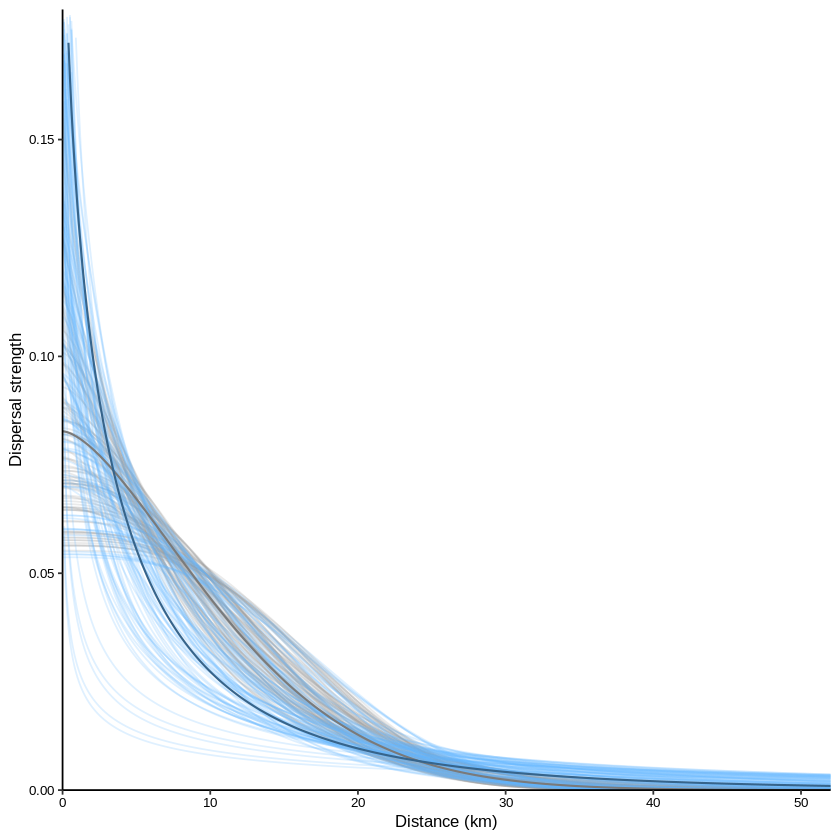

In [257]:
disp_seasonality_pub <- ggplot()+ 
    geom_line(data=to_plot_SWM_df2, aes(x=dist, pdf, group=iter), color="gray60", alpha=0.2)+
    geom_line(data=to_plot_NEM_df2, aes(x=dist, pdf, group=iter), color="steelblue1", alpha=0.2)+    
    geom_line(data=kernel_SWM, aes(x=dist, y=pdf), color="gray48", size=0.6)+
    geom_line(data=kernel_NEM, aes(x=dist, y=pdf), color="steelblue4", size=0.6)+
    theme(panel.grid.major = element_blank(),
    plot.margin=unit(c(0.2,0.2,0.2,0.2),"cm"),#,
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black"), 
    axis.text.x = element_text(size=8, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=8, color="black", family="Helvetica"),
    axis.title.y =  element_text(size=10, color="black", family="Helvetica"), 
    axis.title.x =  element_text(size=10, color="black", family="Helvetica")) +
    xlab("Distance (km)") + ylab("Probability density") + 
    guides(fill=FALSE)+
    scale_x_continuous(limits = c(0,52), expand = c(0, 0), breaks=c(seq(0, 50, 10))) +
    scale_y_continuous(expand = c(0,0), limits = c(0,.18)) +
    xlab("Distance (km)") + ylab("Dispersal strength") 







disp_seasonality_pub

In [258]:
ggplot2::ggsave(filename="SeasonalKernels.png",  plot=disp_seasonality_pub, width=83, height=70, dpi=600, units="mm", path="~/parentage/kernel_fitting/1340_loci/final_results/kernel_plots/")


Warning message:
“Removed 8000 rows containing missing values (geom_path).”Warning message:
“Removed 8107 rows containing missing values (geom_path).”Warning message:
“Removed 80 rows containing missing values (geom_path).”Warning message:
“Removed 84 rows containing missing values (geom_path).”